## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from influxdb_client import InfluxDBClient

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing the Data and Pre-processing 

In [4]:
df = pd.read_csv("dataframe_11g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
n_days = 11
df = df.drop(columns=['pressure', 'temperature', 'people'])
df

,humidity
time,
2020-07-07 13:30:00+00:00,44.45
2020-07-07 13:35:00+00:00,44.30
2020-07-07 13:40:00+00:00,44.30
2020-07-07 13:45:00+00:00,44.05
2020-07-07 13:50:00+00:00,44.05
...,...
2020-07-18 13:05:00+00:00,47.35
2020-07-18 13:10:00+00:00,47.35
2020-07-18 13:15:00+00:00,47.35


# Fill NaN values

In [5]:
df['humidity'] = df['humidity'].fillna(method='backfill').fillna(method='ffill')

In [6]:
points_per_day = int(len(df)/n_days) 
points_per_day

288

In [7]:
print(df['humidity'].isnull().sum())

0


# Split the dataset

In [8]:
# divide in train e test
#size = int(len(df)*0.8)
size = len(df)-points_per_day
df_train, df_test = df.iloc[:size], df.iloc[size:]

# Dickey–Fuller test

In [9]:
sts.adfuller(df.humidity) # non stazionaria

(-2.508104170625958,
 0.11351492395948476,
 18,
 3149,
 {'1%': -3.432428322829966,
  '5%': -2.8624582751958285,
  '10%': -2.5672588193169945},
 -734.6126810362912)

## The LLR Test

In [10]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Auto Correlation Function (ACF)

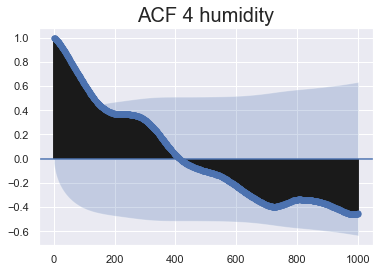

In [11]:
sgt.plot_acf(df.humidity, zero = False, lags = 1000)
plt.title("ACF 4 humidity", size = 20)
plt.show()

## Partial Auto Correlation Function (PACF)

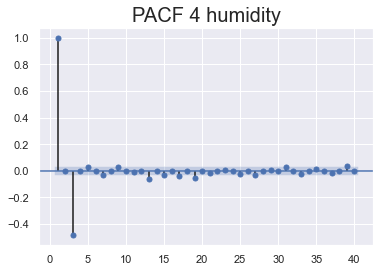

In [12]:
sgt.plot_pacf(df.humidity, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF 4 humidity", size = 20)
plt.show()

# Humidity

In [13]:
start_date = df_test.index[0]
end_date = df_test.index[24]#df_test.index[points_per_day-1]

## AR

In [14]:
print("AR(1)")
model_h_ar_1 = SARIMAX(df_train.humidity, order=(1,0,0))
results_h_ar_1 = model_h_ar_1.fit()
print(results_h_ar_1.summary())

print("AR(2)") #PARAMETRI NON SIGNIFICATIVI
model_h_ar_2 = SARIMAX(df_train.humidity, order=(2,0,0))
results_h_ar_2 = model_h_ar_2.fit()
print(results_h_ar_2.summary())

print("AR(3)") #PARAMETRI NON SIGNIFICATIVI
model_h_ar_3 = SARIMAX(df_train.humidity, order=(3,0,0))
results_h_ar_3 = model_h_ar_3.fit()
print(results_h_ar_3.summary())

print("AR(4)") #PARAMETRI NON SIGNIFICATIVI
model_h_ar_4 = ARIMA(df_train.humidity, order=(4,0,0))
results_h_ar_4 = model_h_ar_4.fit()
print(results_h_ar_4.summary())

print("AR(5)") #PARAMETRI NON SIGNIFICATIVI
model_h_ar_5 = ARIMA(df_train.humidity, order=(5,0,0))
results_h_ar_5 = model_h_ar_5.fit()
print(results_h_ar_5.summary())

AR(1)
                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -100.671
Date:                Mon, 20 Jul 2020   AIC                            205.341
Time:                        14:35:24   BIC                            217.272
Sample:                    07-07-2020   HQIC                           209.642
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    8.5e-05   1.18e+04      0.000       1.000       1.000
sigma2         0.0626      0.001    118.150      0.000       0.062       0.064
Ljung-Box (Q):                      937.52   J

In [15]:
print("AR(1):  \t LL = ", results_h_ar_1.llf, "\t AIC = ", results_h_ar_1.aic)

AR(1):  	 LL =  -100.6705441074861 	 AIC =  205.3410882149722


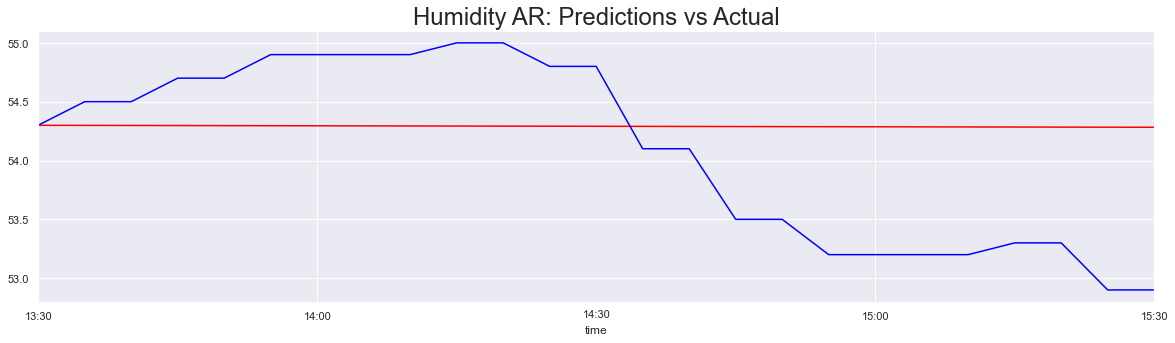

MAE 0.6839936837438717
MSE 0.6075215504069166


In [16]:
df_pred = results_h_ar_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Humidity AR: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

## MA

In [17]:
model_h_ma_1 = SARIMAX(df_train.humidity, order=(0,0,1))
results_h_ma_1 = model_h_ma_1.fit()
print(results_h_ma_1.summary())

model_h_ma_2 = ARIMA(df_train.humidity, order=(0,0,2))
results_h_ma_2 = model_h_ma_2.fit(start_ar_lags=100)
print(results_h_ma_2.summary())

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -13014.630
Date:                Mon, 20 Jul 2020   AIC                          26033.260
Time:                        14:35:30   BIC                          26045.191
Sample:                    07-07-2020   HQIC                         26037.560
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9951      0.002    451.204      0.000       0.991       0.999
sigma2       492.0204     66.854      7.360      0.000     360.989     623.052
Ljung-Box (Q):                    51585.20   Jarque-

In [18]:
print("MA(1):  \t LL = ", results_h_ma_1.llf, "\t AIC = ", results_h_ma_1.aic)
print("MA(2):  \t LL = ", results_h_ma_2.llf, "\t AIC = ", results_h_ma_2.aic)

MA(1):  	 LL =  -13014.62998567981 	 AIC =  26033.25997135962
MA(2):  	 LL =  -5388.333194435075 	 AIC =  10784.66638887015


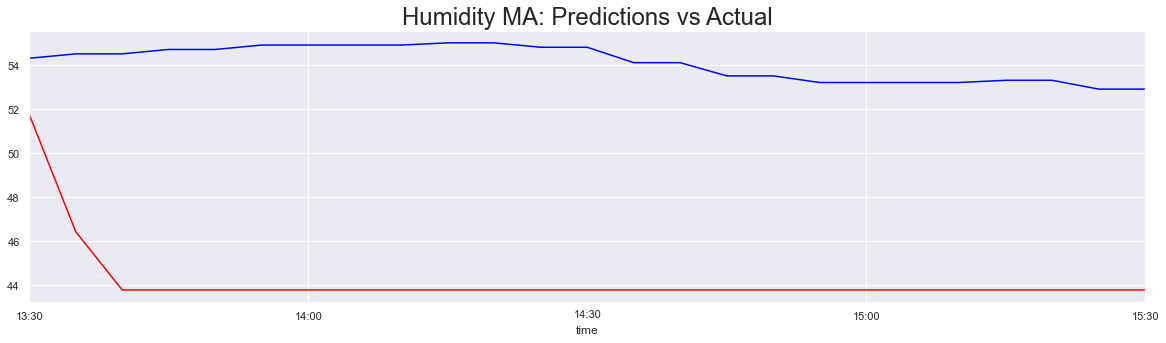

MAE 9.886400096825197
MSE 100.73756689157264


In [19]:
df_pred = results_h_ma_2.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Humidity MA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

## ARMA

In [20]:
print("\nARMA(1,1)") #NON SIGNIFICATIVO
results_h_ar_1_ma_1 = ARMA(df_train.humidity, order=(1,1)).fit()
print(results_h_ar_1_ma_1.summary())

print("\nARMA(2,1)") 
results_h_ar_2_ma_1 = ARMA(df_train.humidity, order=(2,1)).fit()
print(results_h_ar_2_ma_1.summary())

print("\nARMA(1,2)") #NON SIGNIFICATIVO
results_h_ar_1_ma_2 = ARMA(df_train.humidity, order=(1,2)).fit()
print(results_h_ar_1_ma_2.summary())

print("\nARMA(2,2)") #NON SIGNIFICATIVO
results_h_ar_2_ma_2 = ARMA(df_train.humidity, order=(2,2)).fit()
print(results_h_ar_2_ma_2.summary())

print("\nARMA(3,1)") #NON SIGNIFICATIVO
results_h_ar_3_ma_1 = ARMA(df_train.humidity, order=(3,1)).fit()
print(results_h_ar_3_ma_1.summary())

print("\nARMA(1,3)") #NON SIGNIFICATIVO
results_h_ar_1_ma_3 = ARMA(df_train.humidity, order=(1,3)).fit()
print(results_h_ar_1_ma_3.summary())

print("\nARMA(3,2)") #NON SIGNIFICATIVO
results_h_ar_3_ma_2 = ARMA(df_train.humidity, order=(3,2)).fit()
print(results_h_ar_3_ma_2.summary())

print("\nARMA(2,3)") 
results_h_ar_2_ma_3 = ARMA(df_train.humidity, order=(2,3)).fit()
print(results_h_ar_2_ma_3.summary())

print("\nARMA(3,3)") #NON SIGNIFICATIVO
results_h_ar_3_ma_3 = ARMA(df_train.humidity, order=(3,3)).fit()
print(results_h_ar_3_ma_3.summary())


ARMA(1,1)
                              ARMA Model Results                              
Dep. Variable:               humidity   No. Observations:                 2880
Model:                     ARMA(1, 1)   Log Likelihood                 -97.849
Method:                       css-mle   S.D. of innovations              0.250
Date:                Mon, 20 Jul 2020   AIC                            203.698
Time:                        14:35:32   BIC                            227.560
Sample:                    07-07-2020   HQIC                           212.299
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             46.1311      3.856     11.964      0.000      38.574      53.688
ar.L1.humidity     0.9990      0.001   1365.548      0.000       0.998       1.000
ma.L1.humidity     0.0002

                              ARMA Model Results                              
Dep. Variable:               humidity   No. Observations:                 2880
Model:                     ARMA(1, 3)   Log Likelihood                 224.991
Method:                       css-mle   S.D. of innovations              0.224
Date:                Mon, 20 Jul 2020   AIC                           -437.982
Time:                        14:35:40   BIC                           -402.189
Sample:                    07-07-2020   HQIC                          -425.081
                         - 07-17-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             45.4455      3.124     14.549      0.000      39.323      51.568
ar.L1.humidity     0.9983      0.001    968.998      0.000       0.996       1.000
ma.L1.humidity     0.0007      0.018

In [21]:
print("ARMA(2,1):  \t LL = ", results_h_ar_2_ma_1.llf, "\t AIC = ", results_h_ar_2_ma_1.aic)
print("ARMA(2,3):  \t LL = ", results_h_ar_2_ma_3.llf, "\t AIC = ", results_h_ar_2_ma_3.aic)

ARMA(2,1):  	 LL =  -7.239607556691226 	 AIC =  24.479215113382452
ARMA(2,3):  	 LL =  245.6318646548848 	 AIC =  -477.2637293097696


In [22]:
print("\nARMA(1,1) vs ARMA(2,3) ",LLR_test(results_h_ar_1_ma_1, results_h_ar_2_ma_3, DF=1))


ARMA(1,1) vs ARMA(2,3)  0.0


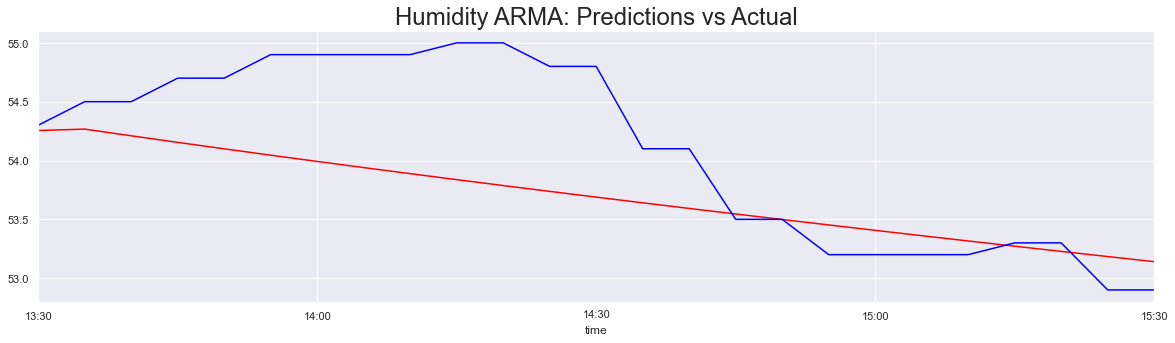

MAE 0.4948675509398814
MSE 0.40974504205973383


In [23]:
df_pred = results_h_ar_2_ma_3.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Humidity ARMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))

## ARIMA

In [24]:
print("\nARIMA(1,1,1)") #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_1 = SARIMAX(df_train.humidity, order=(1,1,1)).fit()
print(results_h_ar_1_i_1_ma_1.summary())

print("\nARIMA(2,1,1)")
results_h_ar_2_i_1_ma_1 = SARIMAX(df_train.humidity, order=(2,1,1)).fit()
print(results_h_ar_2_i_1_ma_1.summary())

print("\nARIMA(1,1,2)") #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_2 = SARIMAX(df_train.humidity, order=(1,1,2)).fit()
print(results_h_ar_1_i_1_ma_2.summary())

print("\nARIMA(1,1,3)") #NON SIGNIFICATIVO
results_h_ar_1_i_1_ma_3 = SARIMAX(df_train.humidity, order=(1,1,3)).fit()
print(results_h_ar_1_i_1_ma_3.summary())

print("\nARIMA(3,1,1)") 
results_h_ar_3_i_1_ma_1 = SARIMAX(df_train.humidity, order=(3,1,1)).fit()
print(results_h_ar_3_i_1_ma_1.summary())

print("\nARIMA(3,1,2)") #NON SIGNIFICATIVO
results_h_ar_3_i_1_ma_2 = SARIMAX(df_train.humidity, order=(3,1,2)).fit()
print(results_h_ar_3_i_1_ma_2.summary())

print("\nARIMA(3,1,3)") 
results_h_ar_3_i_1_ma_3 = SARIMAX(df_train.humidity, order=(3,1,3)).fit()
print(results_h_ar_3_i_1_ma_3.summary())


############################

print("\nARIMA(1,2,1)") 
results_h_ar_1_i_2_ma_1 = SARIMAX(df_train.humidity, order=(1,2,1)).fit()
print(results_h_ar_1_i_2_ma_1.summary())

print("\nARIMA(2,2,1)") 
results_h_ar_2_i_2_ma_1 = SARIMAX(df_train.humidity, order=(2,2,1)).fit()
print(results_h_ar_2_i_2_ma_1.summary())

print("\nARIMA(1,2,2)") 
results_h_ar_1_i_2_ma_2 = SARIMAX(df_train.humidity, order=(1,2,2)).fit()
print(results_h_ar_1_i_2_ma_2.summary())

print("\nARIMA(2,2,2)") #NON SIGNIFICATIVO
results_h_ar_2_i_2_ma_2 = SARIMAX(df_train.humidity, order=(2,2,2)).fit()
print(results_h_ar_2_i_2_ma_2.summary())


print("\nARIMA(1,2,3)") 
results_h_ar_1_i_2_ma_3 = SARIMAX(df_train.humidity, order=(1,2,3)).fit()
print(results_h_ar_1_i_2_ma_3.summary())

print("\nARIMA(3,2,1)") #NON SIGNIFICATIVO
results_h_ar_3_i_2_ma_1 = SARIMAX(df_train.humidity, order=(3,2,1)).fit()
print(results_h_ar_3_i_2_ma_1.summary())

print("\nARIMA(3,2,2)") #NON SIGNIFICATIVO
results_h_ar_3_i_2_ma_2 = SARIMAX(df_train.humidity, order=(3,2,2)).fit()
print(results_h_ar_3_i_2_ma_2.summary())

print("\nARIMA(3,2,3)") #NON SIGNIFICATIVO
results_h_ar_3_i_2_ma_3 = SARIMAX(df_train.humidity, order=(3,2,3)).fit()
print(results_h_ar_3_i_2_ma_3.summary())



ARIMA(1,1,1)
                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -95.358
Date:                Mon, 20 Jul 2020   AIC                            196.717
Time:                        14:35:51   BIC                            214.612
Sample:                    07-07-2020   HQIC                           203.167
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        1.54e-07   6819.709   2.26e-11      1.000   -1.34e+04    1.34e+04
ma.L1      -3.013e-07   8823.975  -3.41e-11      1.000   -1.73e+04    1.73e+04
sigma2         0.0626      0.001    11

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 278.545
Date:                Mon, 20 Jul 2020   AIC                           -545.090
Time:                        14:35:56   BIC                           -509.299
Sample:                    07-07-2020   HQIC                          -532.189
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       2.236e-05    279.290   8.01e-08      1.000    -547.398     547.398
ar.L2          0.4360      0.032     13.438      0.000       0.372       0.500
ar.L3       -4.31e-06    402.482  -1.07e-08      1.0

                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 2880
Model:               SARIMAX(2, 2, 2)   Log Likelihood                 273.861
Date:                Mon, 20 Jul 2020   AIC                           -537.722
Time:                        14:36:18   BIC                           -507.898
Sample:                    07-07-2020   HQIC                          -526.972
                         - 07-17-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0005      0.374      0.001      0.999      -0.733       0.734
ar.L2          0.4779      0.009     55.188      0.000       0.461       0.495
ma.L1         -1.0000      0.591     -1.691      0.0

In [25]:
print("ARMA(2,1,1):  \t LL = ", results_h_ar_2_i_1_ma_1.llf, "\t AIC = ", results_h_ar_2_i_1_ma_1.aic)
print("ARMA(3,1,1):  \t LL = ", results_h_ar_3_i_1_ma_1.llf, "\t AIC = ", results_h_ar_3_i_1_ma_1.aic)
print("ARMA(3,1,3):  \t LL = ", results_h_ar_3_i_1_ma_3.llf, "\t AIC = ", results_h_ar_3_i_1_ma_3.aic)
print("ARMA(1,2,1):  \t LL = ", results_h_ar_1_i_2_ma_1.llf, "\t AIC = ", results_h_ar_1_i_2_ma_1.aic)
print("ARMA(2,2,1):  \t LL = ", results_h_ar_2_i_2_ma_1.llf, "\t AIC = ", results_h_ar_2_i_2_ma_1.aic)
print("ARMA(1,2,2):  \t LL = ", results_h_ar_1_i_2_ma_2.llf, "\t AIC = ", results_h_ar_1_i_2_ma_2.aic)
print("ARMA(1,2,3):  \t LL = ", results_h_ar_1_i_2_ma_3.llf, "\t AIC = ", results_h_ar_1_i_2_ma_3.aic)

ARMA(2,1,1):  	 LL =  277.696723905932 	 AIC =  -547.393447811864
ARMA(3,1,1):  	 LL =  277.6967239044957 	 AIC =  -545.3934478089914
ARMA(3,1,3):  	 LL =  278.54495784316333 	 AIC =  -543.0899156863267
ARMA(1,2,1):  	 LL =  93.5128442253741 	 AIC =  -181.0256884507482
ARMA(2,2,1):  	 LL =  273.86125585274976 	 AIC =  -539.7225117054995
ARMA(1,2,2):  	 LL =  131.56912102495406 	 AIC =  -255.13824204990811
ARMA(1,2,3):  	 LL =  229.34118353025602 	 AIC =  -448.68236706051204


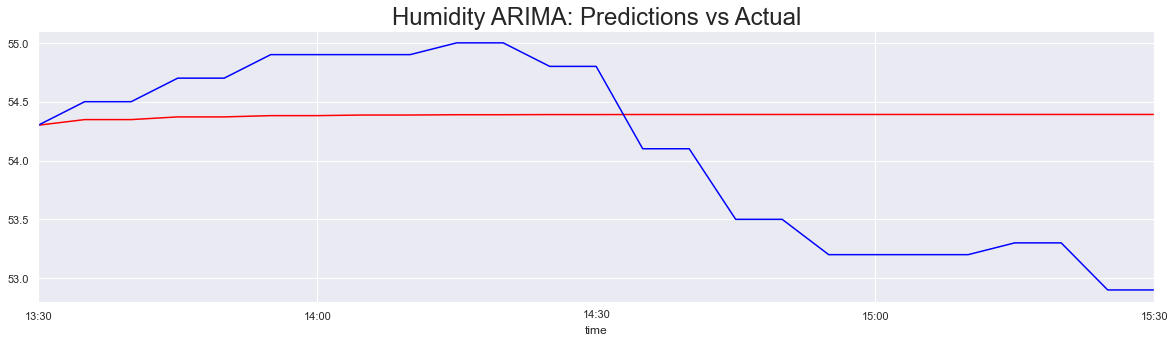

MAE 0.6945381471035347
MSE 0.667075805544103


In [26]:
df_pred = results_h_ar_2_i_1_ma_1.predict(start = start_date, end = end_date)

df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.humidity[start_date:end_date].plot(color = "blue")
plt.title("Humidity ARIMA: Predictions vs Actual", size = 24)
plt.show()                          

print("MAE "+str(mean_absolute_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))
print("MSE "+str(mean_squared_error(df_test.humidity[start_date:end_date], df_pred[start_date:end_date])))